# 0 Estrutura e Configuração do Projeto
- A Fase 0 tem como objetivo garantir que todo o ambiente experimental está corretamente organizado e configurado antes de qualquer processamento de imagens médicas ou extração de features. Esta etapa é crítica para assegurar reprodutibilidade, rastreabilidade e robustez em projetos de Deep Learning aplicados a imagens médicas, tal como recomendado nas boas práticas de engenharia de dados e ciência reprodutível.

- Nesta fase são criadas todas as pastas necessárias, definido o ficheiro de configuração global (`config.yaml`), validados os parâmetros críticos e fixadas as seeds para garantir consistência nos resultados. Além disso, são preparados os caminhos e variáveis que serão utilizados ao longo de todo o pipeline, incluindo nas fases posteriores de extração de volumes, criação de crops 3D e obtenção de embeddings com CNNs tridimensionais.

###  0.1. Estrutura de Pastas
- Cria a hierarquia de diretórios necessária para o pipeline completo.

- Estas pastas garantem a separação entre dados brutos, processados e resultados.

In [23]:
from pathlib import Path
import yaml
import os

# --- Diretório raiz do projeto ---
PROJECT_ROOT = Path.cwd()

# --- Estrutura de pastas ---
PATHS = {
    "dicom_raw": PROJECT_ROOT / "data" / "dicom_raw",
    "cache_npz": PROJECT_ROOT / "data" / "cache_npz",
    "nodules_crops": PROJECT_ROOT / "data" / "nodules_crops",
    "embeddings": PROJECT_ROOT / "data" / "embeddings",
    "splits": PROJECT_ROOT / "splits",
    "cfg": PROJECT_ROOT / "cfg",
    "src": PROJECT_ROOT / "src",
}

# Criar pastas
for p in PATHS.values():
    p.mkdir(parents=True, exist_ok=True)

print(" Estrutura de pastas criada/verificada:")
for k, v in PATHS.items():
    print(f"  └── {k}: {v.relative_to(PROJECT_ROOT)}")

# --- Criar dicionário de configuração ---
CFG = {
    "seed": 42,
    "hu_window": {"min": -1000, "max": 400},
    "target_spacing": [1.0, 1.0, 1.0],
    "crop_size": [48, 48, 48],
    "nodule_diameter_mm": {"min": 3.0, "max": 30.0},
    "paths": {k: str(v.relative_to(PROJECT_ROOT)) for k, v in PATHS.items()},
    "training": {"batch_size": 8, "mixed_precision": True, "num_workers": 4},
}

# Atualizar o caminho real dos DICOMs (manifest LIDC)
CFG["paths"]["dicom_raw"] = "/Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI"

# Caminho do ficheiro de configuração
CFG_PATH = PATHS["cfg"] / "config.yaml"

# Função auxiliar para guardar YAML
def yaml_dump(data):
    return yaml.dump(data, sort_keys=False, allow_unicode=True)

# Guardar config
CFG_PATH.write_text(yaml_dump(CFG), encoding="utf-8")

print(f"\n Configuração guardada em: {CFG_PATH}")


 Estrutura de pastas criada/verificada:
  └── dicom_raw: data/dicom_raw
  └── cache_npz: data/cache_npz
  └── nodules_crops: data/nodules_crops
  └── embeddings: data/embeddings
  └── splits: splits
  └── cfg: cfg
  └── src: src

 Configuração guardada em: /Users/beaseabra/Desktop/dataset/cfg/config.yaml


- verificar que foi tudo feito corretamente 

In [24]:
import yaml
cfg_test = yaml.safe_load(open(CFG_PATH))
print("Leitura OK ")
print(yaml.dump(cfg_test, sort_keys=False))


Leitura OK 
seed: 42
hu_window:
  min: -1000
  max: 400
target_spacing:
- 1.0
- 1.0
- 1.0
crop_size:
- 48
- 48
- 48
nodule_diameter_mm:
  min: 3.0
  max: 30.0
paths:
  dicom_raw: /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI
  cache_npz: data/cache_npz
  nodules_crops: data/nodules_crops
  embeddings: data/embeddings
  splits: splits
  cfg: cfg
  src: src
training:
  batch_size: 8
  mixed_precision: true
  num_workers: 4



| Pasta                 | Conteúdo                                                        | Motivo / Função                                                                        |
| --------------------- | --------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| `data/dicom_raw/`     | DICOMs originais (CTs brutos), organizados por paciente/estudo. | Mantém os dados de origem intactos e reprodutíveis. É a “fonte da verdade” do dataset. |
| `data/cache_npz/`     | Volumes reamostrados e normalizados em HU.                      | Evita reler e converter DICOMs a cada execução, garantindo consistência e eficiência.  |
| `data/nodules_crops/` | Cubos 3D centrados nos nódulos.                                 | Fornece os *inputs diretos* para as CNNs 3D ou *feature extractors*.                   |
| `data/embeddings/`    | Vetores de *features* extraídos após a CNN.                     | Servem de entrada para classificadores (ex.: SVM, XGBoost) em fases posteriores.       |
| `splits/`             | Listas `train/val/test` por paciente.                           | Evita *data leakage* entre doentes, assegurando separação correta.                     |
| `cfg/`                | Ficheiros de configuração (`config.yaml`).                      | Centraliza os hiperparâmetros e permite reprodutibilidade.                             |
| `src/`                | Código modular (funções auxiliares).                            | Mantém o notebook limpo e facilita a reutilização de funções.                          |


- A estrutura modularizada segue as recomendações de Pianykh (2012) em DICOM: A Practical Introduction and Survival Guide e as boas práticas propostas por Wilson et al. (2017) em Good Enough Practices in Scientific Computing, que defendem a separação entre dados brutos, processados e resultados para assegurar rastreabilidade total.

### 0.2 Ficheiro de Configuração Global (`config.yaml`)
- Cria ou lê o ficheiro (`cfg/config.yaml`), garantindo consistência entre runs.

- O ficheiro (`config.yaml`) funciona como o núcleo paramétrico do projeto, garantindo que todos os valores (como tamanho do crop, janela HU e batch size) são centralizados e facilmente reprodutíveis. Este tipo de configuração externa é considerado uma boa prática em Machine Learning Engineering (Beazley, Python Cookbook, O’Reilly), pois separa a lógica experimental dos parâmetros experimentais, promovendo transparência e versionamento.


In [25]:
import json
from pathlib import Path

DEFAULT_CFG = {
    "seed": 42,
    "hu_window": {"min": -1000, "max": 400},
    "target_spacing": [1.0, 1.0, 1.0],
    "crop_size": [48, 48, 48],
    "nodule_diameter_mm": {"min": 3.0, "max": 30.0},
    "paths": {k: str(v.relative_to(PROJECT_ROOT)) for k, v in PATHS.items()},
    "training": {"batch_size": 8, "mixed_precision": True, "num_workers": 4},
}

CFG_DIR = PATHS["cfg"]
CFG_PATH = CFG_DIR / "config.yaml"

def yaml_load(text: str) -> dict:
    try:
        import yaml
        return yaml.safe_load(text) or {}
    except Exception:
        d = {}
        for line in text.splitlines():
            if ":" in line:
                k, v = line.split(":", 1)
                d[k.strip()] = v.strip()
        return d

def yaml_dump(obj: dict) -> str:
    try:
        import yaml
        return yaml.safe_dump(obj, sort_keys=False, allow_unicode=True)
    except Exception:
        import pprint
        return pprint.pformat(obj, sort_dicts=False)

def deep_update(base: dict, new: dict) -> dict:
    for k, v in (new or {}).items():
        if isinstance(v, dict) and isinstance(base.get(k), dict):
            base[k] = deep_update(base[k], v)
        else:
            base[k] = v
    return base

CFG_DIR.mkdir(parents=True, exist_ok=True)
if CFG_PATH.exists():
    user_cfg = yaml_load(CFG_PATH.read_text(encoding="utf-8"))
    CFG = deep_update(DEFAULT_CFG.copy(), user_cfg)
else:
    CFG = DEFAULT_CFG.copy()
    CFG_PATH.write_text(yaml_dump(CFG), encoding="utf-8")

print(" Config carregada/escrita em:", CFG_PATH.relative_to(PROJECT_ROOT))
print(CFG)


 Config carregada/escrita em: cfg/config.yaml
{'seed': 42, 'hu_window': {'min': -1000, 'max': 400}, 'target_spacing': [1.0, 1.0, 1.0], 'crop_size': [48, 48, 48], 'nodule_diameter_mm': {'min': 3.0, 'max': 30.0}, 'paths': {'dicom_raw': '/Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI', 'cache_npz': 'data/cache_npz', 'nodules_crops': 'data/nodules_crops', 'embeddings': 'data/embeddings', 'splits': 'splits', 'cfg': 'cfg', 'src': 'src'}, 'training': {'batch_size': 8, 'mixed_precision': True, 'num_workers': 4}}


### 0.3 Validação da Configuração
- Confere coerência entre parâmetros críticos como HU window, spacing e crop size.

- Esta célula assegura a consistência interna da configuração, prevenindo erros futuros no pipeline. Parâmetros como o windowing HU e o resampling spacing são baseados em recomendações de Gonzalez & Woods (2018) no livro Digital Image Processing, que destaca a importância da uniformidade na aquisição e transformação de imagens médicas.

In [26]:
def _as_list(x, n=None, typ=float):
    if isinstance(x, (list, tuple)):
        out = list(x)
    else:
        out = [x]
    if n is not None and len(out) != n:
        raise ValueError(f"Esperava lista de tamanho {n}, obtido {out}")
    return [typ(v) for v in out]

hu_min = float(CFG["hu_window"]["min"])
hu_max = float(CFG["hu_window"]["max"])
if not (hu_min < hu_max):
    raise ValueError(f"hu_window inválido: min={hu_min} >= max={hu_max}")

spacing = _as_list(CFG["target_spacing"], 3, float)
if not all(s > 0 for s in spacing):
    raise ValueError(f"target_spacing tem valores não positivos: {spacing}")

crop = _as_list(CFG["crop_size"], 3, int)
if any(c % 2 == 0 for c in crop):
    print("Aviso: 'crop_size' tem lados pares. Usar valores ímpares melhora a centragem do nódulo.")

print("Validações concluídas.")


Aviso: 'crop_size' tem lados pares. Usar valores ímpares melhora a centragem do nódulo.
Validações concluídas.


- Escolha do tamanho do crop. Neste trabalho uso 48×48×48 porque é mais leve e compatível com a maioria das CNNs 3D pré-treinadas, acelerando a extração de features e reduzindo uso de memória — especialmente relevante sem GPU. A opção 49³ tem elegância geométrica (voxel central perfeito), mas o ganho prático nas embeddings é marginal face ao custo extra. Como o foco aqui é feature extraction (não segmentação de margens finas), 48³ oferece o melhor equilíbrio entre precisão e eficiência; se mais tarde eu precisar de centragem exata, posso recortar novamente em 49³ sem alterar o restante pipeline

### 0.4 Fixar Seeds e Determinismo
- Garante reprodutibilidade de resultados em TensorFlow ou PyTorch.

- A fixação de seeds e ativação de determinismo garantem que o modelo se comporta da mesma forma em execuções repetidas. Esta abordagem é fundamental em investigação científica, pois assegura que os resultados são replicáveis — conceito amplamente discutido por Goodfellow, Bengio e Courville em Deep Learning (MIT Press, 2016), que enfatizam a importância do controlo de aleatoriedade em experiências de Machine Learning.

In [27]:
import os, random
import numpy as np

seed = int(CFG.get("seed", 42))
random.seed(seed)
np.random.seed(seed)
os.environ.setdefault("PYTHONHASHSEED", str(seed))
os.environ.setdefault("TF_DETERMINISTIC_OPS", "1")

BACKEND = "none"
mp_enabled = False

try:
    import tensorflow as tf
    BACKEND = "tensorflow"
    tf.random.set_seed(seed)
    for g in tf.config.list_physical_devices("GPU"):
        tf.config.experimental.set_memory_growth(g, True)
    if CFG["training"]["mixed_precision"]:
        from tensorflow.keras import mixed_precision as mp
        mp.set_global_policy("mixed_float16")
        mp_enabled = True
except Exception:
    try:
        import torch
        BACKEND = "pytorch"
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        BACKEND = "none"

print(f"Backend: {BACKEND}")
print(f"• Mixed precision: {'ativada' if mp_enabled else 'desativada'}")


Backend: pytorch
• Mixed precision: desativada


In [28]:
# Diagnóstico rápido de mixed precision no PyTorch
try:
    import torch
    print("PyTorch:", torch.__version__)
    print("CUDA disponível:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
    from pprint import pprint
    print("\ntraining cfg:")
    pprint(CFG.get("training", {}))
except Exception as e:
    print("PyTorch não está disponível:", e)


PyTorch: 2.4.1
CUDA disponível: False

training cfg:
{'batch_size': 8, 'mixed_precision': True, 'num_workers': 4}


- Sobre o uso de mixed precision: A mixed precision training foi desativada porque o ambiente atual não dispõe de GPU (CUDA = False). Este modo utiliza operações em float16 para acelerar o treino em GPUs modernas, mas em CPU não traz benefícios e pode até reduzir o desempenho. Por esse motivo, a configuração mantém mixed_precision: false, podendo ser reativada futuramente quando o projeto for executado com suporte CUDA.

### 0.5 Guardar Configuração Normalizada e Resumo
- Esta última célula persiste a configuração normalizada e imprime um resumo completo, garantindo transparência sobre o estado atual do ambiente antes de avançar para a Fase 1 (Leitura de DICOMs e Conversão para HU).

In [29]:
CFG_PATH.write_text(yaml_dump(CFG), encoding="utf-8")

print("Config final guardada em:", CFG_PATH.relative_to(PROJECT_ROOT))
print("\nResumo do Projeto:")
for k, v in CFG.items():
    print(f"{k}: {v}")


Config final guardada em: cfg/config.yaml

Resumo do Projeto:
seed: 42
hu_window: {'min': -1000, 'max': 400}
target_spacing: [1.0, 1.0, 1.0]
crop_size: [48, 48, 48]
nodule_diameter_mm: {'min': 3.0, 'max': 30.0}
paths: {'dicom_raw': '/Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI', 'cache_npz': 'data/cache_npz', 'nodules_crops': 'data/nodules_crops', 'embeddings': 'data/embeddings', 'splits': 'splits', 'cfg': 'cfg', 'src': 'src'}
training: {'batch_size': 8, 'mixed_precision': True, 'num_workers': 4}


## 1. DICOM → HU → Reamostragem Isotrópica (1 mm)

- A Fase 1 transforma séries DICOM em volumes 3D em HU, windowizados ([-1000, 400]), normalizados para [0,1] e reamostrados para 1×1×1 mm, guardando tudo em (`data/cache_npz/{patient}.npz`).
Isto estabiliza a geometria e acelera as fases seguintes (crops 3D e embeddings).

### 1.1 Leitura da série DICOM (ordenada) + metadados
- o manifeste esta da forma : (`…/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-…/3000566.000000-NA-03192/*.dcm`). Nos defenimos uma serie como uma paste que contem um conjunto de (`.dcm`) do mesmo exame (tipicamente dezenas/centenas).Sendo que cada paciente pode ter varias series 

- esta função que criamos usa (`rglob(*.dcm)`) para percorrer todos os níveis e deteta como séries as pastas que têm pelo menos N ficheiros DICOM (por defeito, min_dicoms=10).

- Assim, não importa quão fundo esteja a pasta da série , será encontrada.

- Ordenamos as slices por (`ImagePositionPatient[2]`) (eixo Z). Se faltar, usamos (`InstanceNumber`) como fallback.

- Empilhamos em [D,H,W] (D = nº de slices), preservando a fidelidade espacial.

- Calculamos o spacing [dz, dy, dx] em mm a partir de:

    - Z: diferença entre as posições (IPP[2]) de duas slices consecutivas (mais fiável que  SliceThickness); fallback para SliceThickness se não existir IPP.
    
    - Y,X: PixelSpacing = [dy, dx].
    
Isto assegura que o volume respeita a geometria do doente.

- função utilitaria

In [30]:
def find_dicom_series_dirs(root: Path, min_dicoms: int = 10):
    """
    Percorre recursivamente 'root' e devolve as pastas que contêm
    pelo menos 'min_dicoms' ficheiros DICOM (*.dcm).
    """
    root = Path(root)
    series_dirs = []
    for dirpath in root.rglob("*"):
        if dirpath.is_dir():
            dcm_files = list(dirpath.glob("*.dcm"))
            if len(dcm_files) >= min_dicoms:
                series_dirs.append(dirpath)
    return series_dirs

In [31]:
from pathlib import Path
import numpy as np
import pydicom

def load_dicom_series(series_dir: Path):
    """
    Lê uma série DICOM (pasta com .dcm) e devolve:
      - vol_raw: volume [D,H,W] em int16 (raw)
      - spacing: np.array([dz, dy, dx], mm)
      - origin: ImagePositionPatient do primeiro slice (se existir)
      - slope, intercept: para converter para HU
      - meta: dicionário mínimo (UIDs, PatientID)
    """
    series_dir = Path(series_dir)
    files = sorted([p for p in series_dir.glob("*.dcm")])
    if not files:
        raise FileNotFoundError(f"Sem DICOMs em {series_dir}")

    # Ler todos os cabeçalhos (se tiver transferência comprimida, instala 'pylibjpeg' ou 'gdcm')
    slices = [pydicom.dcmread(str(f), stop_before_pixels=False) for f in files]

    # Ordenar por posição no paciente (fallback: InstanceNumber)
    def sort_key(ds):
        if hasattr(ds, "ImagePositionPatient"):
            return float(ds.ImagePositionPatient[2])  # eixo Z (crescentes)
        return int(getattr(ds, "InstanceNumber", 0))
    slices.sort(key=sort_key)

    # Volume [D,H,W] (raw)
    vol_raw = np.stack([ds.pixel_array for ds in slices]).astype(np.int16)

    # Spacing (z, y, x)
    try:
        ipp0, ipp1 = slices[0].ImagePositionPatient, slices[1].ImagePositionPatient
        dz = abs(ipp1[2] - ipp0[2])
    except Exception:
        dz = float(getattr(slices[0], "SliceThickness", 1.0))
    dy, dx = getattr(slices[0], "PixelSpacing", [1.0, 1.0])
    spacing = np.array([dz, float(dy), float(dx)], dtype=np.float32)

    origin = np.array(getattr(slices[0], "ImagePositionPatient", [0,0,0]), dtype=np.float32)
    slope = float(getattr(slices[0], "RescaleSlope", 1.0))
    intercept = float(getattr(slices[0], "RescaleIntercept", 0.0))
    meta = {
        "SeriesInstanceUID": getattr(slices[0], "SeriesInstanceUID", None),
        "StudyInstanceUID": getattr(slices[0], "StudyInstanceUID", None),
        "PatientID": getattr(slices[0], "PatientID", series_dir.name),
    }
    return vol_raw, spacing, origin, slope, intercept, meta


In [32]:
# 1) Verifica que a config existe
assert "CFG" in globals(), "CFG não definido. Corre a célula 0.x primeiro (configuração)."

# 2) Caminho base dos DICOMs (manifest LIDC)
dicom_root = Path(CFG["paths"]["dicom_raw"])
assert dicom_root.exists(), f"Caminho inválido: {dicom_root}"

# 3) Encontrar uma pasta com >=10 ficheiros DICOM
series_dirs = find_dicom_series_dirs(dicom_root, min_dicoms=10)
assert series_dirs, f"Nenhuma série encontrada em {dicom_root}. Confirma o caminho."

# usar a primeira série encontrada (ou muda o índice para testar outra)
test_series = series_dirs[0]
print(f"📂 Série selecionada:\n{test_series}\n({len(list(test_series.glob('*.dcm')))} ficheiros)")

# 4) Ler volume com a função implementada na Fase 1
vol_raw, spacing, origin, slope, intercept, meta = load_dicom_series(test_series)

# 5) Mostrar resultados básicos
print("\n Volume shape:", vol_raw.shape, "| dtype:", vol_raw.dtype)
print(" Spacing [dz,dy,dx]:", spacing, "| Origin:", origin)
print(" Slope / Intercept:", slope, intercept)
print(" PatientID:", meta.get("PatientID"))

# 6) Checks automáticos
assert vol_raw.ndim == 3 and vol_raw.dtype == np.int16, "Volume deve ser 3D e int16"
assert spacing.shape == (3,) and (spacing > 0).all(), "Spacing inválido"
assert np.isfinite(vol_raw).all(), "Volume contém NaN ou Inf"

print("\n Validação 1.1 concluída com sucesso!")

📂 Série selecionada:
/Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-NA-NA-61676/3000702.000000-NA-08261
(238 ficheiros)

 Volume shape: (238, 512, 512) | dtype: int16
 Spacing [dz,dy,dx]: [1.25     0.898438 0.898438] | Origin: [-229.   -215.   -297.75]
 Slope / Intercept: 1.0 -1024.0
 PatientID: LIDC-IDRI-0125

 Validação 1.1 concluída com sucesso!


In [33]:
# Escolhe uma pasta-série real do manifest (usa o scanner da 1.4 para listar)
from pathlib import Path
test_series = next(iter(find_dicom_series_dirs(Path(CFG["paths"]["dicom_raw"]), min_dicoms=10)))  # 1ª série encontrada

vol_raw, spacing, origin, slope, intercept, meta = load_dicom_series(test_series)

print("DIR:", test_series)
print("vol_raw shape:", vol_raw.shape, "dtype:", vol_raw.dtype)
print("spacing [dz,dy,dx]:", spacing)
print("origin:", origin)
print("slope/intercept:", slope, intercept)
print("PatientID:", meta.get("PatientID"))

# checks
assert vol_raw.ndim == 3 and vol_raw.dtype == np.int16
assert spacing.shape == (3,) and (spacing > 0).all()
assert np.isfinite(vol_raw).all()


DIR: /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-NA-NA-61676/3000702.000000-NA-08261
vol_raw shape: (238, 512, 512) dtype: int16
spacing [dz,dy,dx]: [1.25     0.898438 0.898438]
origin: [-229.   -215.   -297.75]
slope/intercept: 1.0 -1024.0
PatientID: LIDC-IDRI-0125


### 1.2 HU + windowing + normalização [0,1]


- HU = slope * pixel + intercept (valores do cabeçalho DICOM).

- Guardamos como float32. HU dá-nos uma escala física e comparável entre exames e máquinas.

- Fazemos clip(HU, -1000, 400) — janela que cobre parênquima pulmonar e estruturas relevantes para nódulos.

- Normalizamos essa janela para [0,1].

- Resultado: intensidades comparáveis, sem saturações extremas que atrapalham a rede.

In [34]:
import numpy as np

def to_hu(volume_int16, slope: float, intercept: float):
    hu = volume_int16.astype(np.float32) * slope + intercept
    return hu.astype(np.float32)

def window_and_normalize(hu_volume: np.ndarray, wl_min: float, wl_max: float, out_range=(0.0, 1.0)):
    v = np.clip(hu_volume, wl_min, wl_max)
    lo, hi = out_range
    v = (v - wl_min) / (wl_max - wl_min + 1e-8)
    v = v * (hi - lo) + lo
    return v.astype(np.float32)


In [35]:
hu = to_hu(vol_raw, slope, intercept)
v  = window_and_normalize(hu, CFG["hu_window"]["min"], CFG["hu_window"]["max"], out_range=(0.0,1.0))

print("HU stats  (min/mean/max):", float(hu.min()), float(hu.mean()), float(hu.max()))
print("WIN stats (min/mean/max):", float(v.min()),  float(v.mean()),  float(v.max()))
print("dtype:", v.dtype)

# checks
assert hu.dtype == np.float32 and v.dtype == np.float32
assert np.isfinite(hu).all() and np.isfinite(v).all()
# depois do window, valores ficam em [0,1] (com tolerância numérica)
assert v.min() >= -1e-5 and v.max() <= 1+1e-5


HU stats  (min/mean/max): -3023.0 -857.0847778320312 8061.0
WIN stats (min/mean/max): 0.0 0.26352840662002563 1.0
dtype: float32


### 1.3 Reamostragem isotrópica (1×1×1 mm)
- Queremos voxels cúbicos com 1 mm de lado: target_spacing = [1,1,1].

- Calculamos os fatores de zoom como spacing_in / target.

- Interpolamos o volume com ordem 1 (linear) (imagem).

    - Quando trabalhares com máscaras (segmentações), usa ordem 0 (nearest) para não criar rótulos fracionários.
    
- Resultado: volume_iso [D', H', W'], com spacing_out = [1,1,1].


In [36]:
from scipy.ndimage import zoom
import numpy as np

def resample_isotropic(volume: np.ndarray, spacing_in, target=(1.0,1.0,1.0), order=1):
    spacing_in = np.array(spacing_in, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    # volume está [D,H,W] ≡ [z,y,x] → fatores na mesma ordem
    zoom_factors = spacing_in / target
    v_iso = zoom(volume, zoom=zoom_factors, order=order)
    return v_iso.astype(np.float32), zoom_factors


In [37]:
vol_iso, zoom_f = resample_isotropic(v, spacing, target=CFG["target_spacing"], order=1)

print("zoom_factors [z,y,x]:", zoom_f)
print("vol_iso shape:", vol_iso.shape, "dtype:", vol_iso.dtype)

# checks
assert vol_iso.ndim == 3 and vol_iso.dtype == np.float32
assert np.isfinite(vol_iso).all()
assert np.allclose(zoom_f, spacing / np.array(CFG["target_spacing"], dtype=np.float32))


zoom_factors [z,y,x]: [1.25     0.898438 0.898438]
vol_iso shape: (298, 460, 460) dtype: float32


### 1.4 Scanner recursivo (manifest LIDC-IDRI) + processamento e cache


- varre todos os níveis do manifest, identifica pastas-série (≥N DICOMs), processa e guarda data/cache_npz/{patient_id}.npz.

In [38]:
from pathlib import Path
import json
import numpy as np

def find_dicom_series_dirs(root: Path, min_dicoms=10):
    """Varre recursivamente; devolve pastas que parecem ser séries (>= min_dicoms .dcm)."""
    root = Path(root)
    series_dirs = []
    for dirpath in root.rglob("*"):
        if not dirpath.is_dir():
            continue
        if len(list(dirpath.glob("*.dcm"))) >= min_dicoms:
            series_dirs.append(dirpath)
    return series_dirs

def process_patient_series(series_dir: Path, cfg: dict, out_dir: Path):
    vol_raw, spacing, origin, slope, intercept, meta = load_dicom_series(series_dir)
    vol_hu = to_hu(vol_raw, slope, intercept)

    wl = cfg["hu_window"]
    vol_w = window_and_normalize(vol_hu, wl["min"], wl["max"], out_range=(0.0, 1.0))

    vol_iso, zoom_f = resample_isotropic(vol_w, spacing, target=cfg["target_spacing"], order=1)

    # sanity
    assert np.isfinite(vol_iso).all(), "NaN/Inf no volume reamostrado."
    patient_id = (meta.get("PatientID") or series_dir.name)

    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{patient_id}.npz"
    np.savez_compressed(
        out_path,
        volume=vol_iso.astype(np.float32),
        spacing=np.array(cfg["target_spacing"], dtype=np.float32),
        origin=origin.astype(np.float32),
        meta=json.dumps(meta),
    )
    return {
        "patient_id": patient_id,
        "in_shape": tuple(vol_raw.shape),
        "out_shape": tuple(vol_iso.shape),
        "spacing_in": tuple(map(float, spacing)),
        "spacing_out": tuple(cfg["target_spacing"]),
        "zoom_factors": tuple(map(float, zoom_f)),
        "out_path": str(out_path),
        "series_dir": str(series_dir),
    }

# --- Executar num subconjunto (ajusta 'n_series') ---
raw_root = Path(CFG["paths"]["dicom_raw"]) if Path(CFG["paths"]["dicom_raw"]).is_absolute() else (PROJECT_ROOT / CFG["paths"]["dicom_raw"])
series_dirs = find_dicom_series_dirs(raw_root, min_dicoms=10)
print(f" séries encontradas: {len(series_dirs)}")
for p in series_dirs[:3]:
    print("  •", p)

out_dir = PROJECT_ROOT / CFG["paths"]["cache_npz"]
n_series = min(3, len(series_dirs))   # começa por 3 para testar
reports = [process_patient_series(s, CFG, out_dir) for s in series_dirs[:n_series]]
print("\n Processamento concluído (amostra):")
for r in reports:
    print(r)


 séries encontradas: 654
  • /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-NA-NA-61676/3000702.000000-NA-08261
  • /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0317/01-01-2000-NA-CT LUNG SCREEN-00031/NA-56720
  • /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0541/01-01-2000-NA-NA-89260/5515.000000-NA-39652

 Processamento concluído (amostra):
{'patient_id': 'LIDC-IDRI-0125', 'in_shape': (238, 512, 512), 'out_shape': (298, 460, 460), 'spacing_in': (1.25, 0.8984379768371582, 0.8984379768371582), 'spacing_out': (1.0, 1.0, 1.0), 'zoom_factors': (1.25, 0.8984379768371582, 0.8984379768371582), 'out_path': '/Users/beaseabra/Desktop/dataset/data/cache_npz/LIDC-IDRI-0125.npz', 'series_dir': '/Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-NA-NA-61676/3000702.000000-NA-08261'}
{'patient_id': 'LIDC-IDRI-0317', 'in_shape': (124, 512, 512), 'out_shape': (310, 315, 315), 'spacing_in

- primeiro verificamos se o scanner vê tudo 

In [39]:
raw_root = Path(CFG["paths"]["dicom_raw"])
series_dirs = find_dicom_series_dirs(raw_root, min_dicoms=10)

print("Séries detetadas:", len(series_dirs))
for p in series_dirs[:3]:
    print("  •", p, "  (#dcm:", len(list(p.glob("*.dcm"))), ")")

assert len(series_dirs) > 0, "Nenhuma série encontrada — confere o caminho do manifest e a profundidade."


Séries detetadas: 654
  • /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-NA-NA-61676/3000702.000000-NA-08261   (#dcm: 238 )
  • /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0317/01-01-2000-NA-CT LUNG SCREEN-00031/NA-56720   (#dcm: 124 )
  • /Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0541/01-01-2000-NA-NA-89260/5515.000000-NA-39652   (#dcm: 111 )


- De seguida verificamos se a cache esta correta 

In [40]:
out_dir = PROJECT_ROOT / CFG["paths"]["cache_npz"]
rep = process_patient_series(series_dirs[0], CFG, out_dir)

print("Relatório:", rep)
npz = np.load(rep["out_path"])
print("NPZ keys:", list(npz.keys()))
print("volume:", npz["volume"].shape, npz["volume"].dtype, " spacing:", npz["spacing"])

# checks
assert Path(rep["out_path"]).exists()
assert "volume" in npz and "spacing" in npz and "meta" in npz
assert npz["volume"].dtype == np.float32
assert np.allclose(npz["spacing"], np.array(CFG["target_spacing"], dtype=np.float32))


Relatório: {'patient_id': 'LIDC-IDRI-0125', 'in_shape': (238, 512, 512), 'out_shape': (298, 460, 460), 'spacing_in': (1.25, 0.8984379768371582, 0.8984379768371582), 'spacing_out': (1.0, 1.0, 1.0), 'zoom_factors': (1.25, 0.8984379768371582, 0.8984379768371582), 'out_path': '/Users/beaseabra/Desktop/dataset/data/cache_npz/LIDC-IDRI-0125.npz', 'series_dir': '/Users/beaseabra/Desktop/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-NA-NA-61676/3000702.000000-NA-08261'}
NPZ keys: ['volume', 'spacing', 'origin', 'meta']
volume: (298, 460, 460) float32  spacing: [1. 1. 1.]


### 1.5 Sanity checks visuais (axial/sagital/coronal):

- Sanity visual (3 cortes ortogonais)

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def show_slices(volume: np.ndarray, title: str = ""):
    """
    Mostra 3 vistas ortogonais (axial, sagital, coronal) de um volume 3D.
    Espera volume normalizado (ex.: [0,1]) com shape [D,H,W].
    """
    assert volume.ndim == 3, f"Esperava [D,H,W], recebi {volume.shape}"
    D, H, W = volume.shape
    zc, yc, xc = D // 2, H // 2, W // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(volume[zc], cmap="gray");       axes[0].set_title("Axial")
    axes[1].imshow(volume[:, yc, :], cmap="gray"); axes[1].set_title("Sagital")
    axes[2].imshow(volume[:, :, xc], cmap="gray"); axes[2].set_title("Coronal")
    for ax in axes: ax.axis("off")
    if title: fig.suptitle(title)
    plt.tight_layout()
    plt.show()


Usando volume de: /Users/beaseabra/Desktop/dataset/data/cache_npz/LIDC-IDRI-0125.npz
shape: (298, 460, 460) | dtype: float32 | min/max: 0.0 1.0


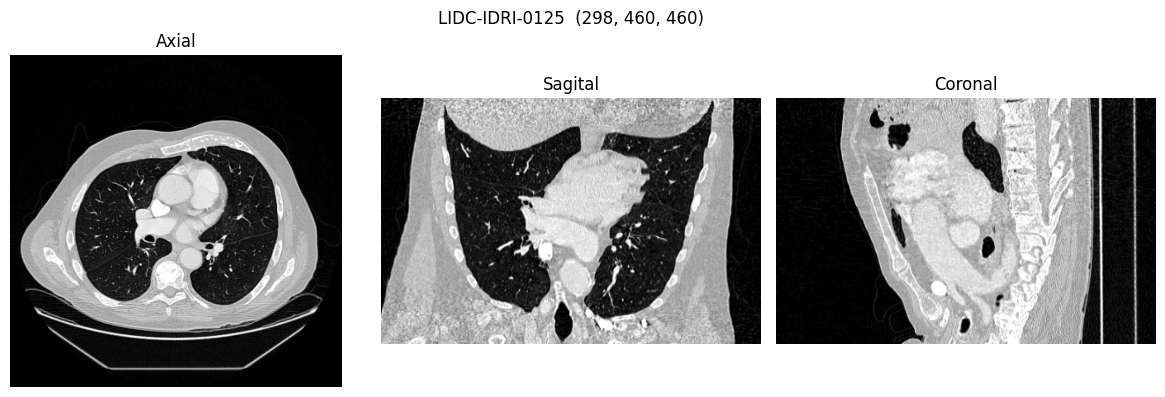

In [42]:
import numpy as np
from pathlib import Path

# 1) Se acabaste de correr a 1.4, podes usar 'reports':
try:
    _ = reports  # apenas para verificar se existe
    npz_info = reports[0]
    npz_path = Path(npz_info["out_path"])
    print("Usando volume de:", npz_path)
except NameError:
    # 2) Caso contrário, escolhe o primeiro .npz disponível na cache:
    cache_dir = Path(PROJECT_ROOT) / CFG["paths"]["cache_npz"]
    npz_path = sorted(cache_dir.glob("*.npz"))[0]
    print("Usando volume de:", npz_path)

data = np.load(npz_path)
vol = data["volume"]  # esperado: float32, normalizado
print("shape:", vol.shape, "| dtype:", vol.dtype, "| min/max:", float(vol.min()), float(vol.max()))

# checks rápidos
assert vol.ndim == 3, "Volume deve ser [D,H,W]"
assert vol.dtype == np.float32, "Volume deve ser float32"
assert np.isfinite(vol).all(), "Volume tem NaN/Inf"
assert -1e-4 <= vol.min() <= 0.05 and 0.95 <= vol.max() <= 1.0001, "Range esperado ~[0,1] após window/normalize"

# mostra cortes
show_slices(vol, title=f"{npz_path.stem}  {vol.shape}")


### 1.6 Criar um index.csv do cache

- criamos  splits/cache_index.csv com inventário de volumes.

In [43]:
import csv, numpy as np
from pathlib import Path

def build_cache_index(cache_dir: Path, index_csv: Path):
    rows = []
    npz_files = list(sorted(Path(cache_dir).glob("*.npz")))
    if not npz_files:
        raise FileNotFoundError(f"Sem .npz em {cache_dir}. Processa pacientes na 1.4 primeiro.")
    for npz_path in npz_files:
        npz = np.load(npz_path)
        vol = npz["volume"]
        rows.append({
            "patient_id": npz_path.stem,
            "path_npz": str(npz_path),
            "shape_d": int(vol.shape[0]),
            "shape_h": int(vol.shape[1]),
            "shape_w": int(vol.shape[2]),
        })
    index_csv.parent.mkdir(parents=True, exist_ok=True)
    with open(index_csv, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader(); w.writerows(rows)
    return index_csv

# Exemplo:
# cache_dir = PROJECT_ROOT / CFG["paths"]["cache_npz"]
# idx_path = PROJECT_ROOT / "splits" / "cache_index.csv"
# print("Index gerado em:", build_cache_index(cache_dir, idx_path))


- verificamos que fizemos esta etapa corretamente 

In [44]:
idx_path = PROJECT_ROOT / "splits" / "cache_index.csv"
print("Index gerado em:", build_cache_index(PROJECT_ROOT / CFG["paths"]["cache_npz"], idx_path))
print(Path(idx_path).read_text().splitlines()[:5])  # ver primeiras linhas


Index gerado em: /Users/beaseabra/Desktop/dataset/splits/cache_index.csv
['patient_id,path_npz,shape_d,shape_h,shape_w', 'LIDC-IDRI-0125,/Users/beaseabra/Desktop/dataset/data/cache_npz/LIDC-IDRI-0125.npz,298,460,460', 'LIDC-IDRI-0317,/Users/beaseabra/Desktop/dataset/data/cache_npz/LIDC-IDRI-0317.npz,310,315,315', 'LIDC-IDRI-0541,/Users/beaseabra/Desktop/dataset/data/cache_npz/LIDC-IDRI-0541.npz,333,394,394']
